# Transplanting Data into Insights: from EDA to Model Building

This notebook is part of a Kaggle competition hosted by the **Center for International Blood and Marrow Transplant Research (CIBMTR)**, aiming to improve survival predictions for patients undergoing allogeneic hematopoietic cell transplantation (HCT). Predicting survival outcomes for HCT patients is a crucial healthcare challenge, but existing models often fall short in addressing disparities linked to socioeconomic status, race, and geography. The goal of the competition is to develop predictive models that are both highly accurate and fair, ensuring that all patients receive equitable and effective care.

**What is Allogeneic HCT?**\
The human immune system relies on hematopoietic stem cells, found in the bone marrow, which generate blood and immune cells. Allogeneic HCT is a medical procedure where faulty hematopoietic stem cells in a patient are replaced with healthy ones from a donor. This can restore a functional immune system, particularly for patients with blood cancers or immune disorders. The source of these stem cells may be bone marrow, peripheral blood, or umbilical cord blood.

**Let's get started**\
This notebook will guide you through data exploration, preprocessing, and model development, ultimately working towards improving survival predictions in allogeneic HCT patients. Let’s dive in!

Parts of the code in this notebook are inspired from the following public notebooks:
- https://www.kaggle.com/code/tanujtaneja/single-model-xgboost-nelson-cv-681-lb-685
- https://www.kaggle.com/code/cdeotte/xgboost-catboost-baseline-cv-668-lb-668
- https://www.kaggle.com/code/cdeotte/gpu-lightgbm-baseline-cv-681-lb-685
- https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense

# Evaluation Method

The competition evaluates model performance using a **Stratified Concordance Index (C-index)**, which measures how well the model ranks patients based on their predicted risk scores. The actual survival times do not matter, only the relative ranking of patients based on their predicted risk scores is important. 

The C-index is calculated as shown in the figure below. A C-index of 1.0 indicates perfect ranking, while 0.5 represents random predictions. This compettion uses a stratified form of the C-index, which is calculated as the mean of C-index scores across different racial groups, minus the standard deviation of those scores. This encourages models that perform well consistently across all racial groups, reducing bias in survival predictions

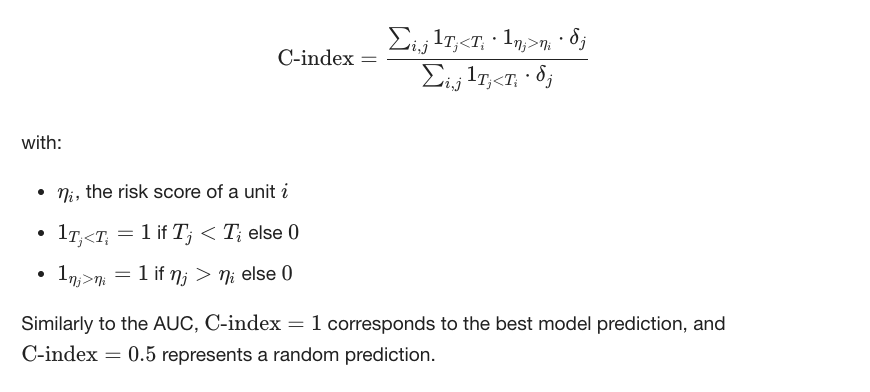

# Data Summary

The dataset consists of **59 columns** related to hematopoietic stem cell transplantation (HSCT), capturing a range of demographic, clinical, and transplant-related factors for both recipients and donors. It is a synthetic dataset, generated using SurvivalGAN, a specialized deep learning model for survival analysis. This allows for robust model development while protecting patient privacy.

To promote fair and equitable predictions, the dataset ensures equal representation across racial groups, including White, Asian, African-American, Native American, Pacific Islander, and More than One Race. This balanced distribution aligns with the competition’s goal of reducing biases in survival predictions across diverse patient populations.

The primary outcome of interest is **event-free survival (EFS)**, represented by the variable  `efs`, while the **time to event-free survival** is captured by `efs_time`. Together, these variables form the target for a censored time-to-event analysis.

Below I give an overview and summary of all features. Note that there appear to be several confliting features.

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Disable warning
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option("display.max_columns", 500)

In [ ]:
!pip install /kaggle/input/pip-install-libaries/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-libaries/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-libaries/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-libaries/formulaic-1.1.1-py3-none-any.whl
!pip install /kaggle/input/pip-install-libaries/lifelines-0.30.0-py3-none-any.whl

!pip install /kaggle/input/pip-install-libaries/ecos-2.0.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install /kaggle/input/pip-install-libaries/scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install /kaggle/input/pip-install-libaries/scikit_survival-0.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [ ]:
# Import data
df_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

df_train.head()

## Feature overview and explanation 

**Outcome variables**
- `efs_time`: Time to event-free survival in months
- `efs`: Event-free survival (EFS), whether an event (e.g., relapse, death) occurred

**General patient and donor information**\
These features provide general information about the transplatation, donor and recipient.
- `year_hct`: The year the transplant was performed
- `age_at_hct`: The age of the recipient at the time of the transplant 
- `donor_age`: The age of the donor
- `race_group`: The race group of the recipient
- `ethnicity`: The ethnicity of the recipient
- `sex_match`: Sex match between donor and recipient
- `donor_related`: Whether the patient and donor are related (Yes/No)
- `cmv_status`: Donor/recipient CMV (Cytomegalovirus) serostatus


**General disease information**
- `prim_disease_hct`: Primary disease for which HCT (hematopoietic cell transplant) is being performed
- `mrd_hct`: Minimal residual disease (MRD) status at the time of transplant
- `dri_score`: Disease risk index (DRI), categorizes the severity of disease
- `cyto_score`: Cytogenetic score, used in disease prognosis
- `cyto_score_detail`: Detailed cytogenetic classification (AML/MDS). This could be (partially) redundant with `cyto_score`.


**Treatment and conditioning background**
- `conditioning_intensity`: Planned conditioning regimen intensity (RIC, MAC, NMA)
- `tbi_status`: Use of Total Body Irradiation (TBI) in conditioning
- `rituximab`: Whether Rituximab was used in conditioning
- `in_vivo_tcd`: Whether in-vivo T-cell depletion (ATG/alemtuzumab) was used
- `melphalan_dose`: Whether Melphalan was used in conditioning
- `gvhd_proph`: Planned Graft-vs-Host Disease (GVHD) prophylaxis treatment

**Graft type**
- There appear to be two features indicating graft type (bone marrow (BM) or pheripheral blood (PB)): `graft_type` and `prod_type`. 

**Comorbidities & Health Conditions**
- `karnofsky_score`: Karnofsky Performance Score (KPS) at HCT, measuring functional status. A high score (80-100) means that the patient is functioning well and able to do normal activities, while a low score (<50) indicates that the patient requires substantial assistence.
- `comorbidity_score`: The comorbidity score (Sorror comorbidity index) quantifies the burden of pre-existing medical conditions to predict transplant-related mortality risk (higher score = worse health).

Listed health conditions and history:
- `psych_disturb`: Presence of psychiatric disturbances
- `diabetes`: Presence of diabetes
- `arrhythmia`: Presence of heart arrhythmia
- `vent_hist`: History of mechanical ventilation
- `renal_issue`: History of solid tumor
- `obesity`: Presence of obesity
- `cardiac`: Prescece of cardiac disease
- `prior_tumor`: History of solid tumor
- `peptic_ulcer`: Prescence of peptic ulcers
- `rheum_issue`: Presence of rheumatologic disease
- `hepatic_mild`, `hepatic_severe`: Presence of mild or severe liver disease
- `pulm_moderate`, `pulm_severe`: Presence of moderate or severe pulmonary disease

**HLA matching**\
HLA matching assesses the compatibility between a recipient and donor based on human leukocyte antigens (HLA), where a higher match (more similarity) is better as it reduces the risk of graft rejection and complications like graft-versus-host disease (GVHD). 

The dataset includes five HLA alleles (A, B, C, DRB1, and DQB1), each reported at both high resolution and low resolution. Additionally, the dataset provides seven aggregate scores by summing the matches across multiple alleles.

- Low resolution matching: `hla_match_a_low`, `hla_match_b_low`, `hla_match_c_low`, `hla_match_drb1_low`, `hla_match_dqb1_low`
- High resolution matching: `hla_match_a_high`, `hla_match_b_high`, `hla_match_c_high`, `hla_match_drb1_high`, `hla_match_dqb1_high`

Aggregate scores:
- `hla_low_res_6` = `hla_match_a_low` + `hla_match_b_low` +  `hla_match_drb1_low`
- `hla_high_res_6` = `hla_match_a_high` + `hla_match_b_high` +  `hla_match_drb1_high`
- `hla_nmdp_6` = `hla_match_a_low` + `hla_match_b_low` +  `hla_match_drb1_high`
- `hla_low_res_8` = `hla_match_a_low` + `hla_match_b_low` +  `hla_match_c_low` +  `hla_match_drb1_low`
- `hla_high_res_8` = `hla_match_a_high` + `hla_match_b_high` +  `hla_match_c_high` +  `hla_match_drb1_high`
- `hla_low_res_10` = `hla_match_a_low` + `hla_match_b_low` +  `hla_match_c_low` +  `hla_match_drb1_low` +  `hla_match_dqb1_low`
- `hla_high_res_10` = `hla_match_a_high` + `hla_match_b_high` +  `hla_match_c_high` +  `hla_match_drb1_high`+  `hla_match_dqb1_high`


**T-Cell Epitope matching**
- `tce_match`: T-cell epitope matching classification
- `tce_div_match`: T-cell epitope matching classification. Appears redundant with `tce_match`.
- `tce_imm_match`: T-cell epitope immunogenicity/diversity match

# Target Engineering

The prediction target constits of two parts: `efs_time` and `efs`:
- When `efs==1`, the patient did not survive and the time of death is `efs_time`
- When `efs==0`, it is unkown if the patient survived or not, but the patient survived at least as long as `efs_time`

In [ ]:
df_target = df_train[["efs", "efs_time"]].copy() # copy the target data in a seperate data frame

# Plot the target distribution
def plot_distribution(x, hue, color="husl", title=None, xlabel="EFS time (months)", ax=None):

    if ax is None:  # Create a standalone figure is no axes is provided 
        fig, ax = plt.subplots(figsize=(6, 4)) 

    # Get unique categories 
    unique_categories = sorted(hue.unique()) 
    palette = sns.color_palette(color, n_colors=len(unique_categories))  

    # Plot histogram with custom palette
    sns.histplot(ax=ax, x=x, hue=hue, edgecolor=None, alpha=0.7, palette=palette)

    ax.set_xlabel(xlabel, fontsize=10) 
    ax.set_ylabel("Count", fontsize=10)
    if title:
        ax.set_title(title, fontsize=12)
    

plot_distribution(df_target["efs_time"], df_target["efs"])
plt.show()

For model training there are two possibilities: 
- Combine `efs_time` and `efs` into a single feature and train a regression model
- Use a model that supports the input of both `efs_time` and `efs` (i.e. Cox)
  
In this notebook, I will use both methods: I will train a XGBOOST model using the Cox loss function and I will transform `efs_time` and `efs` into a single feature using Kaplan-Meier, Nelson-Aalen and quantile transform and train three XGBOOST regression models with MSE loss. 

Note how all transforms strech out the distribution of patients that died (`efs=1`) while compressing the distribution of patients for who we do not know wheter they died (`efs=0`).

In [ ]:
# Functions for target transformation

from lifelines import KaplanMeierFitter
from lifelines import  NelsonAalenFitter
from sklearn.preprocessing import quantile_transform # See https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense


def create_target_COX(data):
    
    data_copy = data.copy()
    data_copy["efs_time2"] = data_copy.efs_time.copy()
    data_copy.loc[data_copy.efs==0,"efs_time2"] *= -1 # Negitated censored data

    return data_copy["efs_time2"]


def create_target_KMF(data):        

    kmf = KaplanMeierFitter()
    kmf.fit(durations=data["efs_time"], event_observed=data["efs"])

    target = kmf.survival_function_at_times(data["efs_time"]).values
    #target[data.efs==0] *= 0.5

    return target


def create_target_nelson(data):
    
    naf = NelsonAalenFitter(nelson_aalen_smoothing=0)
    naf.fit(durations=data["efs_time"], event_observed=data["efs"])
    target = naf.cumulative_hazard_at_times(data["efs_time"]).values * -1
    target[data.efs == 0] = (-(-target[data.efs == 0])**0.5)
    #target[data.efs==0] -= 0.2
    
    return target 


def create_quantile_transform(data):
    time = data["efs_time"]
    event = data["efs"]
    
    transformed = np.full(len(time), np.nan)
    transformed_dead = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
    transformed[event == 1] = transformed_dead
    transformed[event == 0] = transformed_dead.min() - 0.3
    
    return transformed

In [ ]:
# Create and visulalize target distributions

target_cox = create_target_COX(df_target) # Create target cox
target_kmf = create_target_KMF(df_target) # Create target kaplan-meier
target_nelson = create_target_nelson(df_target) # Create target nelson
target_quant = create_quantile_transform(df_target) # Create target quantile transform


fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True) 
axs = axs.flatten()

plot_distribution(target_cox, df_target["efs"], title="Cox", xlabel="Transformed target", ax=axs[0]) # Plot the distribution of the transformed target
plot_distribution(target_kmf, df_target["efs"], title="Kaplan-Meier", xlabel="Transformed target", ax=axs[1])
plot_distribution(target_nelson, df_target["efs"], title="Nelson-Aalen", xlabel="Transformed target", ax=axs[2])
plot_distribution(target_quant, df_target["efs"], title="Quantile transform", xlabel="Transformed target", ax=axs[3])

# Adjust layout for better spacing
fig.suptitle("Target transformations", fontsize=16, fontweight="bold")  # Set overall title
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show()

# Exploratory Data Analysis

In [ ]:
# Define main plotting functions

def plot_barplot(x, data, title=None, ax=None, hue=None, normalize=False, legend_outside=False, tilt_xlabels=False, color="husl"):
    if ax is None:  # Create a standalone figure if no axes are provided 
        fig, ax = plt.subplots(figsize=(6, 4))
    data = data.copy()  # Avoid modifying the original DataFrame
    data[x] = pd.Categorical(data[x], categories=sorted(data[x].dropna().unique()), ordered=True)
    if hue:
        data[hue] = pd.Categorical(data[hue], categories=sorted(data[hue].dropna().unique()), ordered=True)
        palette = sns.color_palette(color, n_colors=data[hue].nunique())  # Get colors from palette
    else:
        palette = sns.color_palette(color, n_colors=data[x].nunique()) 
    if normalize and hue:
        # Compute value counts for each category and normalize within each hue group
        norm_data = data.groupby([x, hue]).size().reset_index(name="count")
        norm_data["percentage"] = norm_data.groupby(x)["count"].transform(lambda x: x / x.sum())
        sns.barplot(x=x, y="percentage", hue=hue, data=norm_data, ax=ax, palette=palette,  edgecolor="white")
        ax.set_ylabel("Proportion")
    else:
        sns.countplot(x=x, hue=hue, data=data, ax=ax, palette=palette, edgecolor="white")
    if title:
        ax.set_title(title)
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    if tilt_xlabels:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


import textwrap
def plot_stacked_countplot(df, x, hue, title=None, color="husl", ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(8, 4))

    # Get unique categories 
    unique_categories = sorted(df[hue].dropna().unique()) 
    palette = sns.color_palette(color, n_colors=len(unique_categories))  
    
    sns.countplot(x=x, hue=hue,  data=df_train, ax=ax, dodge=False, palette=palette)

    if title:
        ax.set_title(title, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Count", fontsize=10)
    ax.set_ylim(0, 5500)
    
    # Automatically wrap x-tick labels
    wrapped_labels = [textwrap.fill(label.get_text(), width=10) for label in ax.get_xticklabels()]
    ax.set_xticklabels(wrapped_labels, fontsize=10)
    
    plt.legend(fontsize=10)  


from sksurv.nonparametric import kaplan_meier_estimator
def plot_survival_curve(df, col, filter_col=None, filter_var=None, title=None, ax=None, color="husl", legend_outside=False):
    
    if ax is None:  # Create a standalone figure if no axes are provided 
        fig, ax = plt.subplots(figsize=(6, 4))

    if filter_col: # Subset dataset by filter_var 
         df_subset = df[df[filter_col] == filter_var]
    else:
        df_subset = df
        
    unique_values = sorted(df_subset[col].dropna().unique())  # Sort categories
    colors = sns.color_palette(color, n_colors=len(unique_values))  # Get colors from palette

    for var, color in zip(unique_values, colors):  # Assign colors dynamically
        mask = df_subset[col] == var

        if mask.sum() == 0:
            continue  # Skip if no samples for this category
            
        time, survival_prob, conf_int = kaplan_meier_estimator(
            df_subset["efs"][mask].astype("bool"),
            df_subset["efs_time"][mask],
            conf_type="log-log")

        ax.step(time, survival_prob, where="post", label=f"{var}", color=color)  
        ax.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color=color)  

    ax.set_ylim(0, 1)
    ax.set_ylabel("Estimated probability of survival")
    ax.set_xlabel("Time (months)")
    if title:
        ax.set_title(title)
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend(loc="best")


# Copy of df_train
df_mod = df_train.copy()

## Recipient demographics as a strong predictor for survival

One of the key objectives of this competition is to ensure equitable outcomes for patients across diverse demographics. To explore the effect of demographics on survival, we will first examine the distribution of race and ethnicity groups in the dataset. Next we will look at age and sex distributions.

**Race and ethnicity**\
As shown below, the dataset includes a balanced representation of race groups, aligning with the competition's goal and the synthetic nature of the data. However, this distribution does not reflect the actual demographics of patients receiving Hematopoietic Cell Transplantation (HCT) in the U.S., where the majority of recipients are predominantly White (~65%)(https://cibmtr.org/CIBMTR/Resources/Summary-Slides-Reports).

Further analysis indicates that both race group and ethnicity are strong predictors of survival outcomes, yet there is no significant interaction between the two, suggesting that their effects on survival operate independently.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
plot_stacked_countplot(df_train, "race_group", "ethnicity", ax=axes[0])
plot_survival_curve(df_train, "race_group", ax=axes[1])

fig.suptitle("Survival curves by race group and ethnicity", fontsize=16, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8)) 
axes = axes.flatten()

for i, race_group in enumerate(df_train["race_group"].unique()):
    plot_survival_curve(df_train,"ethnicity",
                        filter_col="race_group", filter_var=race_group,
                        title=race_group, ax=axes[i])

# Adjust layout to prevent overlap
fig.suptitle("Survival curves by race group and ethnicity", fontsize=16, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

**Recipient age and cofounding variables**

Age is a well-established predictor of long-term survival following hematopoietic cell transplantation (HCT). In our dataset, the age distribution appears somewhat unusual, possibly due to its synthetic nature. However, the overall trend aligns with clinical expectations: younger patients tend to have better long-term survival probabilities.

There are several potential explanations for this. Younger individuals generally have better overall health, as reflected in higher Karnofsky scores and fewer comorbidities. Additionally, the underlying diseases requiring HCT vary significantly by age. Acute leukemias, for example, peak in young adults, while chronic leukemias become more prevalent in older populations. Meanwhile, infants and young children often undergo HCT for entirely different conditions. These factors contribute to the observed survival differences across age groups.


In [ ]:
def categorize_age(age):
    if age <= 2:
        return "1: Baby"
    elif age < 12:
        return "2: Young Child"
    elif age < 19:
        return "3: Teenager"
    elif age < 35:
        return "4: Young Adult"
    elif age < 65:
        return "5: Middle Age"
    else:
        return "6: Elderly"

df_mod["age_category"] = df_train["age_at_hct"].apply(categorize_age)
df_mod["age_category_donor"] = df_train["donor_age"].apply(categorize_age)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
axes=axes.flatten()

sns.histplot(data=df_mod, x="age_at_hct", hue="efs", ax=axes[0], edgecolor=None, binwidth=1, palette="husl")
plot_survival_curve(df_mod, "age_category", ax=axes[1], color="husl")

fig.suptitle("Survival curves by recipient age", fontsize=16, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show()

In [ ]:
def simplify_karnoshsky(karnofsky_score):
    if karnofsky_score == -1: 
        return "Missing"
    elif karnofsky_score >= 80: 
        return "High (80-100)"
    else :
        return "Low (<80)"

def simplify_comorbidity(comorbidity_score):
    if comorbidity_score == -1: 
        return "Missing"
    elif comorbidity_score == 0: 
        return "0: Low"
    elif comorbidity_score <= 3:
        return "1-3: Medium"
    else:
        return "4-10: High"


df_mod["karnofsky_score_simple"] = df_train["karnofsky_score"].apply(simplify_karnoshsky)
df_mod["comorbidity_score_simple"] = df_train["comorbidity_score"].apply(simplify_comorbidity)

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes = axes.flatten()
plot_barplot("age_category", df_mod, hue="karnofsky_score_simple", title="Karnofsky score",
             ax=axes[0], normalize=True, legend_outside=True, tilt_xlabels=True)
plot_barplot("age_category", df_mod, hue="comorbidity_score_simple", title="Comorbidity score",
             ax=axes[1], normalize=True, legend_outside=True, tilt_xlabels=True)
fig.suptitle("Recipient age and Health Metrics", fontsize=16, fontweight="bold")
plt.tight_layout(pad=1)
plt.show()

In [ ]:
def classify_disease(disease):
    acute = {"AML", "ALL", "Other acute leukemia"}
    chronic = {"CML", "MPN", "MDS", "Other leukemia"}
    lymphoma = {"NHL", "HD"}
    bone_marrow_failure = {"SAA"}
    plasma_cell_disorders = {"PCD"}
    solid_tumors = {"Solid tumor"}
    immune_autoimmune = {"IMD", "AI"}
    histiocytic_disorders = {"HIS"}

    if disease in acute:
        return "Acute Leukemia"
    elif disease in chronic:
        return "Chronic Leukemia & Related Disorders"
    elif disease in lymphoma:
        return "Lymphoma"
    elif disease in bone_marrow_failure:
        return "Bone Marrow Failure Syndromes"
    elif disease in plasma_cell_disorders:
        return "Plasma Cell Disorders"
    elif disease in solid_tumors:
        return "Solid Tumors"
    elif disease in immune_autoimmune:
        return "Immune & Autoimmune Disorders"
    elif disease in histiocytic_disorders:
         return "Histiocytic Disorders"
    else:
        return "Other"

df_mod["disease_class"] = df_train["prim_disease_hct"].apply(classify_disease)

fig, axes = plt.subplots(1, 1, figsize=(12, 4)) 
plot_barplot("age_category", df_mod, hue="disease_class", 
             ax=axes, normalize=True, legend_outside=True, color="husl")
fig.suptitle("Recipient age and Primary disease", fontsize=16, fontweight="bold")
plt.tight_layout(pad=1)
plt.show()

**Sex and Transplant Outcomes**

The distribution of donor and recipient sex in the dataset is relatively homogeneous, and sex alone does not appear to have a strong effect on survival. However, sex-matched transplants (M-M and F-F) show better survival probabilities compared to sex-mismatched transplants (F-M and M-F). This could be due to:
- Female → Male Transplants (F-M): Higher risk of graft-versus-host disease (GVHD), likely because female donors may have been sensitized to H-Y antigens from previous pregnancies.
- Male → Female Transplants (M-F): May lead to different immune responses, but generally carry a lower GVHD risk than F-M transplants.

In [ ]:
df_mod[["donor_sex", "recipient_sex"]] = df_mod["sex_match"].str.split("-", expand=True)
df_mod[["donor_sex", "recipient_sex"]] = df_mod[["donor_sex", "recipient_sex"]].fillna("Missing")

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
axes=axes.flatten()

#sns.histplot(data=df_mod, x="donor_sex", hue="efs", ax=axes[0], edgecolor="white", binwidth=1, palette="husl")
plot_barplot("donor_sex", df_mod, ax=axes[0])
plot_survival_curve(df_mod, "donor_sex", ax=axes[1], color="husl")
plot_barplot("recipient_sex", df_mod, ax=axes[2])
plot_survival_curve(df_mod, "recipient_sex", ax=axes[3], color="husl")
plot_barplot("sex_match", df_mod, ax=axes[4], tilt_xlabels=True)
plot_survival_curve(df_mod, "sex_match", ax=axes[5], color="husl", legend_outside=True)
for i in range(6, len(axes)):  # Remove empty subplots
    fig.delaxes(axes[i])
    
fig.suptitle("Survival curves by donor and recipient sex", fontsize=16, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show()

## HLA Matching and Its Unexpected Impact on Survival

HLA (Human Leukocyte Antigen) matching plays a critical role in hematopoietic cell transplantation (HCT), as it helps reduce the risk of graft rejection and complications such as graft-versus-host disease (GVHD). HLA proteins allow the immune system to differentiate between self and non-self, making a close match between donor and recipient essential for transplant success. Typically, the best match comes from a sibling with identical HLA alleles, but when that is not an option, unrelated donors or haploidentical (half-matched) family members may be considered.

**HLA Matching in the Dataset**\
The dataset includes five key HLA alleles—A, B, C, DRB1, and DQB1—each reported at both high resolution and low resolution. Additionally, seven aggregate HLA scores summarize the level of matching across multiple alleles. However, the dataset contains 70,612 missing values in the HLA-related columns. Notably, these missing values are not randomly distributed—when an individual HLA match (either high or low resolution) is missing, the corresponding aggregate scores are also missing. Fortunately, the redundancy between high- and low-resolution data allows us to impute missing values where possible.

**Unexpected Relationship Between HLA Matching and Survival**\
When analyzing the effect of HLA matching on survival probability, we observe a counterintuitive trend: patients with lower HLA matches seem to have better long-term survival outcomes. This finding appears contradictory to established medical knowledge, where a higher HLA match is typically associated with better transplant success and lower complications.

The unexpected trend of lower HLA matches correlating with better long-term survival may be influenced by several factors. Patients with mismatched transplants often receive more aggressive conditioning, intensive immunosuppression, or alternative GVHD prophylaxis, which could improve outcomes despite the mismatch. Additionally, haploidentical transplants (e.g., from parents or children) may occur earlier in the disease course, while fully matched unrelated donors take longer to secure, potentially leading to later-stage transplants with worse prognoses. Differences in treatment strategies, transplant timing, and disease stage likely contribute to this pattern, suggesting that HLA matching alone is not the sole determinant of survival.


In [ ]:
def impute_hla_columns(df, fill_with_mean=False):
    # For each locus (A, B, C, DRB1, DQB1)
    loci = ['a', 'b', 'c', 'drb1', 'dqb1']
    
    for locus in loci:
        high_col = f'hla_match_{locus}_high'
        low_col = f'hla_match_{locus}_low'
        
        # Impute missing low resolution with high resolution and vice versa
        df[low_col].fillna(df[high_col], inplace=True)
        df[high_col].fillna(df[low_col], inplace=True)

        if fill_with_mean:
            # Check where both high and low are missing
            missing_rows = df[high_col].isna() & df[low_col].isna()
            
            # For rows where both are missing, impute with the rounded mean of the available high and low columns in that row
            for idx in df[missing_rows].index:
                # Get all available values in the current row from high and low resolution columns
                row_values = df.loc[idx, [f'hla_match_{locus}_high' for locus in loci] + [f'hla_match_{locus}_low' for locus in loci]].dropna()
                
                if len(row_values) > 0:
                    # Calculate the row-wise mean and round it
                    mean_value = row_values.mean().round()
                    
                    # Assign the rounded mean value to the missing high and low resolution columns
                    df.loc[idx, high_col] = mean_value
                    df.loc[idx, low_col] = mean_value
    
    return df


def impute_sum_columns(df):
    
    # Impute missing values in sum columns based on sum of individual high/low res features
    df['hla_low_res_6'].fillna(
        df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_low'], 
        inplace=True)

    df['hla_nmdp_6'].fillna(
        df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_high'], 
        inplace=True)
    
    df['hla_low_res_8'].fillna(
        df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low'], 
        inplace=True)
    
    df['hla_low_res_10'].fillna(
        df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low'] + df['hla_match_dqb1_low'], 
        inplace=True)

    df['hla_high_res_6'].fillna(
        df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_drb1_high'], 
        inplace=True)
    
    df['hla_high_res_8'].fillna(
        df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high'], 
        inplace=True)
    
    df['hla_high_res_10'].fillna(
        df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high'] + df['hla_match_dqb1_high'], 
        inplace=True)
    
    return df


# Fill in missing values
df_train_filled = impute_hla_columns(df_train)
df_train_filled = impute_sum_columns(df_train)

In [ ]:
cols_hla = ['hla_match_a_low', 'hla_match_a_high',
           'hla_match_b_low', 'hla_match_b_high',
           'hla_match_c_low', 'hla_match_c_high',
           'hla_match_drb1_low', 'hla_match_drb1_high',
           'hla_match_dqb1_low', 'hla_match_dqb1_high']

fig, axes = plt.subplots(3, 4, figsize=(12, 10)) 
axes = axes.flatten()

for i, col in enumerate(cols_hla):
    plot_survival_curve(df_train_filled, col, title=col, ax=axes[i])
for i in range(len(cols_hla), len(axes)):  # Remove empty subplots
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
fig.suptitle("Survival curves by hla scores per allel", fontsize=16, fontweight="bold")  # Set overall title
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

In [ ]:
cols_hla_sum = ['hla_low_res_6', 'hla_high_res_6',
               'hla_low_res_8', 'hla_high_res_8', 
               'hla_low_res_10', 'hla_high_res_10',
               'hla_nmdp_6']

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
axes = axes.flatten()

for i, col in enumerate(cols_hla_sum):
    plot_survival_curve(df_train_filled, col, title=col, ax=axes[i])
for i in range(len(cols_hla_sum), len(axes)):  # Remove empty subplots
    fig.delaxes(axes[i])
    
# Adjust layout to prevent overlap
fig.suptitle("Survival curves by summed hla scores", fontsize=16, fontweight="bold")  # Set overall title
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

Among the various HLA matching scores available in the dataset, hla_nmpd_6 provides the best separation in terms of survival outcomes. To understand why lower HLA matches appear to correspond to better long-term survival, we need to investigate possible explanations.

**Distribution of HLA_NMDP_6 Scores**\
Examining the frequency of match values reveals that scores of 3 and 6 are the most common. This pattern aligns with donor-recipient relationships:

- HLA match = 6 → Likely a fully matched sibling or an unrelated donor
- HLA match = 3 → Often observed in haploidentical (half-matched) transplants, typically from a parent or child

Missing values (-1) predominantly correspond to related donors, whose match levels can often be inferred based on their relationship. Interestingly, unrelated donors are more likely to be fully matched (score = 6), while related donors (such as parents or children) tend to have lower HLA matches. A key factor could be timing—related donors are available immediately, allowing for earlier transplants when the disease is in a less advanced stage, potentially increasing survival rates despite the lower match.

In [ ]:
plot_barplot("hla_nmdp_6", df_mod, hue="donor_related") 
plt.xlabel("HLA score: nmdp_6")
plt.ylabel("Counts")
plt.show()

**Differences in Treatment Based on HLA Matching**

Another potential explanation lies in treatment differences between highly matched vs. poorly matched transplants:
- Lower HLA matches (e.g., 3) → More Non-Myeloablative (NMA) conditioning, less Reduced-Intensity Conditioning (RIC)
- Lower HLA matches → Higher use of Total Body Irradiation (TBI)

Graft-versus-Host Disease (GVHD) Prophylaxis:
- Lower matches → More cyclophosphamide
- Higher matches → More FK-based prophylaxis

These treatment variations could significantly influence survival outcomes, as different conditioning regimens and immunosuppressive strategies impact transplant success and complication rates. So why not subject all recipients to a more agressive treatment regime (MAC/NMA + TBI) if this results in better outcome? We will answer this question in the next section.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12)) 

# First barplot
plot_barplot("hla_nmdp_6", df_mod, hue="conditioning_intensity", normalize=True, ax=axes[0], legend_outside=True)
axes[0].set_xlabel("HLA score: nmdp_6")  
axes[0].set_ylabel("Proportion by HLA score (%)")  
axes[0].set_title("Score Distribution by Conditioning Intensity")

# Second barplot
plot_barplot("hla_nmdp_6", df_mod, hue="tbi_status", normalize=True, ax=axes[1], legend_outside=True)
axes[1].set_xlabel("HLA score: nmdp_6")  
axes[1].set_ylabel("Proportion by HLA score  (%)")  
axes[1].set_title("Score Distribution by TBI Status")


# Tird barplot
plot_barplot("hla_nmdp_6", df_mod, hue="gvhd_proph", normalize=True, ax=axes[2], legend_outside=True)
axes[2].set_xlabel("HLA score: nmdp_6")  
axes[2].set_ylabel("Proportion by HLA score  (%)")  
axes[2].set_title("Score Distribution by GVHD Prophylaxis")

plt.tight_layout()
plt.show()

## Effects of treatment, conditioning and medical progess

To better understand the impact of different treatment strategies, let's take a closer look at the six key features related to transplant conditioning and post-transplant management:

_Pre-transplant conditioning:_
- `conditioning_intensity`: Planned conditioning regimen intensity (RIC, MAC, NMA)
- `tbi_status`: Use of Total Body Irradiation (TBI) in conditioning
- `rituximab`: Whether Rituximab was used in conditioning
- `melphalan_dose`: Whether Melphalan was used in conditioning

_Post-transplant managment:_
- `in_vivo_tcd`: Whether in-vivo T-cell depletion (ATG/alemtuzumab) was used
- `gvhd_proph`: Planned Graft-vs-Host Disease (GVHD) prophylaxis treatment

**Impact of conditioning on survival**:\
There is a strong correlation between conditioning intensity and survival outcomes. Generally, more aggressive conditioning regimens are associated with better survival rates, likely due to a reduced risk of disease relapse. However, this raises again the question: Why not administer the most aggressive treatment to all patients?

The answer likely lies in patient fitness and tolerance. Not all patients can withstand highly intensive regimens. Indeed, those with lower Karnofsky scores and higher comorbidity scores are more frequently treated with Reduced-Intensity Conditioning (RIC).


In [ ]:
def categorize_tbi(tbi_status):
    if pd.isna(tbi_status) or tbi_status == "No TBI": # "No TBI" is the mode
        return "No TBI"
    elif ">cGy" in tbi_status:
        return "High-Dose TBI"
    elif "Cy"in tbi_status:
        return "TBI + Cy"
    else:
        return "Low-Dose TBI"

In [ ]:
df_mod["tbi_category"] = df_train["tbi_status"].apply(categorize_tbi)
df_mod["conditioning_intensity"] = df_mod["conditioning_intensity"].replace(["N/A, F(pre-TED) not submitted", "No drugs reported"], "TBD")
cat_cols = df_mod.select_dtypes(include=["object", "category"]).columns
num_cols = df_mod.select_dtypes(include=["number"]).columns
df_mod.loc[:, cat_cols] = df_mod[cat_cols].fillna("Missing")
df_mod.loc[:, num_cols] = df_mod[num_cols].fillna(-1)

fig, axes = plt.subplots(4, 2, figsize=(12, 12)) 
axes = axes.flatten()
plot_barplot("conditioning_intensity", df_mod, ax=axes[0], title="Conditioning")
plot_survival_curve(df_mod, "conditioning_intensity", ax=axes[1], title="Conditioning")
plot_barplot("tbi_category", df_mod, ax=axes[2], title="TBI category")
plot_survival_curve(df_mod, "tbi_category", ax=axes[3], title="TBI category")
plot_barplot("rituximab", df_mod, ax=axes[4], title="Rituximab")
plot_survival_curve(df_mod, "rituximab", ax=axes[5], title="Rituximab")
plot_barplot("melphalan_dose", df_mod, ax=axes[6], title="Melphalan")
plot_survival_curve(df_mod, "melphalan_dose", ax=axes[7], title="Melphalan")

fig.suptitle("Conditioning regimes", fontsize=16, fontweight="bold")
plt.tight_layout(pad=1)
plt.show()

In [ ]:
def simplify_karnoshsky(karnofsky_score):
    if karnofsky_score == -1: 
        return "Missing"
    elif karnofsky_score >= 80: 
        return "High (80-100)"
    else :
        return "Low (<80)"

def simplify_comorbidity(comorbidity_score):
    if comorbidity_score == -1: 
        return "Missing"
    elif comorbidity_score == 0: 
        return "0: Low"
    elif comorbidity_score <= 3:
        return "1-3: Medium"
    else:
        return "4-10: High"


df_mod["karnofsky_score_simple"] = df_train["karnofsky_score"].apply(simplify_karnoshsky)
df_mod["comorbidity_score_simple"] = df_train["comorbidity_score"].apply(simplify_comorbidity)

fig, axes = plt.subplots(1, 2, figsize=(12, 3)) 
axes = axes.flatten()
plot_barplot("karnofsky_score_simple", df_mod, hue="conditioning_intensity", 
             ax=axes[0], normalize=True, legend_outside=True)
plot_barplot("comorbidity_score_simple", df_mod, hue="conditioning_intensity", 
             ax=axes[1], normalize=True, legend_outside=True)
fig.suptitle("Distribution of Conditioning Regimens by Patient Health Metrics", fontsize=16, fontweight="bold")
plt.tight_layout(pad=1)
plt.show()

**Impact of GVHD Prophalaxis on survival**\
Graft-versus-host disease (GVHD) is a major complication of allogeneic hematopoietic cell transplantation (HCT), occurring when donor immune cells attack the recipient’s tissues. GVHD prophylaxis plays a crucial role in preventing or reducing the severity of this condition, improving both survival and quality of life.

The choice of prophylaxis regimen depends on factors like disease, donor type, HLA match, and conditioning intensity. While effective GVHD prevention reduces transplant-related mortality, it must also balance the graft-versus-leukemia (GVL) effect, where donor immune cells attack residual cancer cells. Optimizing GVHD prophylaxis is therefore key to improving long-term transplant success.

GVHD prophylaxis is often combinded with in vivo T-cell depletion using antithymocyte globulin (ATG) or alemtuzumab (`in_vivo_tcd`). It is important to distinguish in vivo T-cell depletion from the main GVHD treatment strategy, TDEPLETION, which may involve a broader range of post-transplant immunosuppressive therapies.

In [ ]:
import re

# Define a function to simplify the gvhd_proph column
def simplify_gvhd(row):
    # Remove everything inside parentheses or brackets
    row = re.sub(r"\(.*?\)", "", row)  # Removes text inside parentheses
    row = row.strip()  # Remove extra spaces
    
    # Extract main treatment
    if 'FK' in row:
        main_treatment = 'FK'
    elif 'CSA' in row:
        main_treatment = 'CSA'
    elif 'Cyclophosphamide' in row:
        main_treatment = 'Cyclophosphamide'
    elif 'CDselect' in row:
        main_treatment = 'CDselect'
    elif 'TDEPLETION' in row:
        main_treatment = 'TDEPLETION'
    elif 'No GvHD Prophylaxis' in row:
        main_treatment = 'None'
    elif 'Parent Q' in row:
        main_treatment = 'Parent Q'
    else:
        main_treatment = 'Other'

    # Identify presence of MTX, MMF, and "others"
    has_mtx = 'Yes' if 'MTX' in row else 'No'
    has_mmf = 'Yes' if 'MMF' in row else 'No'
    has_others = 'Yes' if 'other' in row.lower() and 'MTX' not in row and 'MMF' not in row else 'No'

    # Determine Treatment Category
    if has_mtx == 'No' and has_mmf == 'No' and has_others == 'No':
        treatment_category = 'Single Treatment'
    elif has_mtx == 'Yes' and has_mmf == 'No' and has_others == 'No':
        treatment_category = 'Plus MTX'
    elif has_mtx == 'No' and has_mmf == 'Yes' and has_others == 'No':
        treatment_category = 'Plus MMF'
    elif has_mtx == 'No' and has_mmf == 'No' and has_others == 'Yes':
        treatment_category = 'Plus Others'
    else:
         treatment_category = 'Other combination'
    
    return pd.Series([main_treatment, treatment_category])

# Apply function to create new columns
df_mod[["Main_GVHD", "GVHD_Category"]] = df_train["gvhd_proph"].copy().fillna("Other").apply(simplify_gvhd)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
axes = axes.flatten()

plot_barplot("Main_GVHD", df_mod, ax=axes[0], title="Main GVHD treatment", tilt_xlabels=True)
plot_survival_curve(df_mod, "Main_GVHD", ax=axes[1], title="Main GVHD treatment", legend_outside=True)
plot_barplot("GVHD_Category", df_mod, ax=axes[2], title="GVHD Treatment Category", tilt_xlabels=True)
plot_survival_curve(df_mod, "GVHD_Category", ax=axes[3], title="GVHD Treatment Category", legend_outside=True)

fig.suptitle("GVHD regimes", fontsize=16, fontweight="bold")
plt.tight_layout(pad=2)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6)) 
plot_barplot("prim_disease_hct", df_mod, hue="Main_GVHD", 
             ax=axes, normalize=True, legend_outside=True, tilt_xlabels=True)

fig.suptitle("Distribution of GVHD Regimens by Disease", fontsize=16, fontweight="bold")
plt.tight_layout(pad=1)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6)) 
axes = axes.flatten()

plot_barplot("in_vivo_tcd", df_mod, hue="Main_GVHD", ax=axes[0], title="In vivo T-cell Depleteion", tilt_xlabels=True, legend_outside=True)
for i, group in enumerate(df_mod["in_vivo_tcd"].unique()):
    plot_survival_curve(df_mod,"Main_GVHD",
                        filter_col="in_vivo_tcd", filter_var=group,
                        title=f"in vivo TCD: {group}", ax=axes[i+1], legend_outside=True)

# Adjust layout to prevent overlap
fig.suptitle("in vivo TCD and main GVHD treatment", fontsize=16, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

**Medical progress has improved transplant outcomes**

The dataset spans 11 years (2008–2019), with only a handful of entries from 2020. Over this period, medical advancements have led to improved survival probabilities, reflecting continuous refinements in transplant protocols. Notably, conditioning and GVHD prophylaxis strategies have evolved, with a rise in post-transplant cyclophosphamide use and a decline in MMF (mycophenolate mofetil) and MTX (methotrexate). 

In [ ]:
df_mod["year_hct"] = df_mod["year_hct"].replace(2020, 2019)

fig, axes = plt.subplots(1, 1, figsize=(6, 4)) 
plot_survival_curve(df_mod,"year_hct", legend_outside=True, ax=axes) 
fig.suptitle("Survival improves with the years", fontsize=12, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

In [ ]:
def plot_stacked_bar(df, time_col, cat_col, ax=None, palette="husl"):

    # Group by time and categorical column, then count occurrences
    pivot_df = df.groupby([time_col, cat_col]).size().unstack(fill_value=0)

    # Normalize to percentages
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100  

    # Get Seaborn colors
    colors = sns.color_palette(palette, n_colors=len(pivot_df_percent.columns))

    # If no axes are provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Plot stacked bar chart
    pivot_df_percent.plot(kind="bar", stacked=True, color=colors, alpha=0.85, ax=ax)

    # Formatting
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage (%)")
    ax.set_title(f"Distribution of {cat_col} Over Years")
    ax.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
    ax.set_xticks(range(len(pivot_df_percent.index)))  # Ensure correct tick positions
    ax.set_xticklabels(pivot_df_percent.index, rotation=45)  # Rotate x-axis labels for readability
    ax.set_ylim(0, 100)  # Ensure y-axis represents percentage scale

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12)) 
axes = axes.flatten()

plot_stacked_bar(df_mod, "year_hct", "conditioning_intensity", ax=axes[0])
plot_stacked_bar(df_mod, "year_hct", "Main_GVHD", ax=axes[1])
plot_stacked_bar(df_mod, "year_hct", "GVHD_Category", ax=axes[2])

fig.suptitle("Changes in conditioning and GVHD regimes over time", fontsize=12, fontweight="bold")  
plt.tight_layout(pad=1, rect=[0, 0, 1, 0.95])  
plt.show() 

## Cormobidities and overall recipient health are strong predictors for survival

Karnofsky score and comorbidity burden show a strong correlation with survival probabilities, with lower functional status and higher comorbidity scores generally predicting worse outcomes.

Beyond overall comorbidity scores, the dataset includes specific disease indicators such as `diabetes`, `obesity`, and other pre-existing conditions. In most cases, the presence or history of these diseases is associated with lower survival probabilities. However, certain conditions, such as `hepatic_severe` and `peptic_ulcer`, deviate from this trend. This could be due to differences in conditioning regimens or potential selection bias.

An interesting observation is that "Not done" often corresponds to the best survival outcomes. This may be because patients without symptoms are not tested, meaning "Not done" reflects a healthier group than those who were tested and received a negative result.

To further explore the impact of comorbidities, I created two new features by summing the number of diseases with either a positive or negative association with survival. These additional variables may help capture the overall health burden and refine predictive modeling.

In [ ]:
score_cols = ["karnofsky_score", "comorbidity_score"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes = axes.flatten()

for i, col in enumerate(score_cols):
    plot_survival_curve(df_mod, col,
                        title=col, ax=axes[i])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

In [ ]:
disease_cols = ["diabetes", "obesity", "psych_disturb",
                "arrhythmia", "cardiac","vent_hist",
                "hepatic_mild", "hepatic_severe","renal_issue",
                "pulm_moderate", "pulm_severe", "prior_tumor",
                "peptic_ulcer",]

fig, axes = plt.subplots(5, 3, figsize=(12, 12)) 
axes = axes.flatten()

for i, col in enumerate(disease_cols):
    plot_survival_curve(df_mod, col, title=col, ax=axes[i])
for i in range(len(disease_cols), len(axes)):  # Remove empty subplots
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

In [ ]:
def count_diseases(df, cols, new_col_name="disease_count"):
    df_copy = df.copy()
    df_copy[new_col_name] = df_copy[cols].apply(lambda row: row.isin(["Yes"]).sum(), axis=1)
    return df_copy

disease_cols_1 = ["psych_disturb", "diabetes", "arrhythmia",
                  "pulm_severe", "obesity","cardiac",
                  "pulm_moderate", "prior_tumor", "vent_hist"]

disease_cols_2 = ["renal_issue", "hepatic_severe", "peptic_ulcer",
                  "rheum_issue", "hepatic_mild"]

# Add disease count
df_mod = count_diseases(df_mod, disease_cols_1, "disease_count_negative")
df_mod = count_diseases(df_mod, disease_cols_2, "disease_count_positive")


fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes = axes.flatten()

for i, col in enumerate(["disease_count_negative", "disease_count_positive"]):
    plot_survival_curve(df_mod, col,
                        title=col, ax=axes[i])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

## Disease Risk Index (DRI)

The Disease Risk Index (DRI) is a widely used prognostic tool in hematopoietic cell transplantation (HCT) that categorizes patients based on their primary disease, cytogenetic abnormalities, and disease stage at transplant. It helps estimate post-transplant survival by stratifying patients into risk groups ranging from Low to Very High. However, the DRI score does not include certain additional prognostic factors, such as patient fitness, donor type, or transplant-related complications.

To visualize its impact, I plotted a simplified version of the DRI score, which confirms its strong predictive power. Interestingly, the Very High-Risk group shows slightly better survival outcomes than expected, which may be due to selection bias—only the fittest patients within this group proceed to transplant.

I also recalculated the DRI score independently, incorporating primary disease, MRD status at HCT, and cytogenetic risk. While the separation between risk groups in survival analysis was not as distinct as with the provided DRI score, the trend aligned with expectations: patients in the Very High-Risk category had the worst survival outcomes, followed by High, Intermediate, and Low-Risk groups.

In [ ]:
def simplify_dri_score(dri_value):
    # Mappings to simplify dri_scores
    mapping = {
        "Low": "1: Low",
        "Intermediate": "2: Intermediate",
        "High": "3: High",
        "Very high": "4: Very High",
        "Intermediate - TED AML case <missing cytogenetics": "2: Intermediate",
        "High - TED AML case <missing cytogenetics": "3: High",
        "TBD cytogenetics": "0: Unknown",
        "Missing disease status": "0: Unknown",
        "N/A - disease not classifiable": "0: Unknown",
        "N/A - pediatric": "0: Unknown",
        "N/A - non-malignant indication": "1: Low",  # Often considered low-risk
        np.nan: "0: Unknown"  # Handle NaNs
    }
    
    return mapping.get(dri_value, "0: Unknown")  # Default to "Unknown" if not listed


def assign_dri_risk(disease, cyto_score, mrd_hct=None):
    # Define risk groups based on disease
    low_risk = {"IEA", "HIS", "SAA"}  # Low-risk conditions
    intermediate_risk = {"AML", "ALL", "CML", "NHL", "HD", "IMD", "PCD"}  # Common transplant diseases
    high_risk = {"MDS", "MPN", "Other leukemia", "Other acute leukemia"}  # High-risk diseases
    very_high_risk = {"Solid tumor", "IIS", "IPA", "AI"}  # Non-hematologic or aggressive conditions

    if pd.isna(disease) or pd.isna(cyto_score) or cyto_score == "Unknown":
        return "0: Unknown"
    
    # Default risk based on disease
    if disease in low_risk:
        risk = 1  # Low
    elif disease in intermediate_risk:
        risk = 2  # Intermediate
    elif disease in high_risk:
        risk = 3  # High
    elif disease in very_high_risk:
        risk = 4  # Very High
    else:
        return "0: Unknown"

    # Adjust risk based on cytogenetics
    if cyto_score in {"Favorable", "Normal"}:
        risk = max(1, risk - 1)  # Reduce risk level by 1 (min is 1)
    elif cyto_score == "Poor":
        risk = min(4, risk + 1)  # Increase risk level by 1 (max is 4)

    # Adjust risk if MRD at HCT is negative (??? MRD is bad but this seems to work)
    if mrd_hct == "Negative":
        risk = min(4, risk + 1)  # Increase risk level by 1 (max is 4)

    return f"{risk}: {'Low' if risk == 1 else 'Intermediate' if risk == 2 else 'High' if risk == 3 else 'Very High'}"


In [ ]:
# Apply to DataFrame
df_mod["dri_score_custom"] = df_train.apply(lambda row: assign_dri_risk(row["prim_disease_hct"], row["cyto_score_detail"], row["mrd_hct"]), axis=1)
df_mod["dri_simple"] = df_train["dri_score"].apply(simplify_dri_score)

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes = axes.flatten()

plot_survival_curve(df_mod, "dri_score_custom", title="Custom dri-score", ax=axes[0])
plot_survival_curve(df_mod, "dri_simple", title="Simplified dri-score", ax=axes[1])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

## Handeling Redundant and Conflicting Features

The dataset seems to include several conficting or redundant features. These are:
- `graft_type` and `prod_type`
- `cyto_score` and `cyto_score_detail`
- `tce_match` and `tce_div_match`

To address this, I attempted to consolidate these features into single, more consistent variables. However, it remains to be seen whether these adjustments will improve our modeling performance. Regardless, being aware of these inconsistencies is essential for ensuring data quality and making informed analytical decisions.

In [ ]:
df_mod["merged_product_type"] = df_mod["graft_type"] + "_" + df_mod["prod_type"]

cols = ["merged_product_type","graft_type", "prod_type"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
axes = axes.flatten()

for i, col in enumerate(cols):
    plot_survival_curve(df_mod, col,
                        title=col, ax=axes[i])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

In [ ]:
df_mod["cyto_score_"] = df_mod["cyto_score"] + "_"
df_mod["cyto_combined"] = np.where(df_mod["prim_disease_hct"].isin(["AML", "MDS"]),
                                   df_mod["cyto_score_detail"], 
                                   df_mod["cyto_score_"])
df_mod["cyto_combined"] = df_mod["cyto_combined"].replace(["TBD_", "Not tested", "Not tested_"], "TBD")

cols = ["cyto_combined", "cyto_score", "cyto_score_detail"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
axes = axes.flatten()

for i, col in enumerate(cols):
    plot_survival_curve(df_mod, col,
                        title=col, ax=axes[i])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

In [ ]:
def combine_tce_match(row):
    # Define severity ranking
    severity_order = [
        "Missing",
        "Bi-directional non-permissive",
        "GvH non-permissive",
        "HvG non-permissive",
        "Permissive mismatched",
        "Permissive",
        "Fully matched"]
    
    # Get the values from both columns
    tce_1 = row["tce_match"]
    tce_2 = row["tce_div_match"]
    
    # Deal with missing values
    if pd.isna(tce_1) or tce_1 == "Missing":
        return tce_2
    if pd.isna(tce_2) or tce_2 == "Missing":
        return tce_1
    
    # Return the least severe category based on the ranking
    return tce_1 if severity_order.index(tce_1) >  severity_order.index(tce_2) else tce_2

df_mod["tce_combined"] = df_mod.apply(combine_tce_match, axis=1)

cols = ["tce_combined", "tce_match", "tce_div_match"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
axes = axes.flatten()

plot_survival_curve(df_mod, "tce_combined", title="tce_combined", ax=axes[0])
plot_survival_curve(df_mod, "tce_match", title="tce_match", ax=axes[1])
plot_survival_curve(df_mod, "tce_div_match", title="tce_div_match", ax=axes[2])

# Adjust layout to prevent overlap
plt.tight_layout(pad=1)  
plt.show() 

# Custom Transformers for Data Preprocessing
This section defines the custom transformers used for preprocessing the data. These transformers help clean, impute, and enhance the dataset before modeling.

- `DataCleaner`: Handles redundant and conflicting features, replaces categories with very low frequencies, and simplifies certain categorical variables such as DRI score, GVHD prophylaxis, and TBI status.
- `HlaImputer`: Fills in missing values in the HLA columns by leveraging the redundancy between low-resolution and high-resolution HLA features.
- `AttributeAdder`: Creates new features by combining existing ones, enriching the dataset with additional meaningful information.
- `General Preprocessor`: Performs scaling of numerical features, imputes missing values, and sets appropriate data types to ensure consistency before feeding the data into machine learning models.
- `FeatureSelector`: Subsets the dataset by retaining only selected features.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
import re

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, dri_simple=True, tbi_simple=True, gvhd_simple=True, conditioning_simple=True):
        self.dri_simple = dri_simple
        self.tbi_simple = tbi_simple
        self.gvhd_simple = gvhd_simple
        self.conditioning_simple = conditioning_simple
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()

        # Deal with categories with a very low frequency
        X_copy['year_hct']= X_copy['year_hct'].replace(2020, 2019)
        X_copy['karnofsky_score']= X_copy['karnofsky_score'].replace(40, 50) 

        # Deal with conflicting features
        X_copy["graft_type_combined"] = X_copy["graft_type"] + "_" + X_copy["prod_type"]
        X_copy["tce_combined"] = X_copy.apply(self.combine_tce_match, axis=1)
        X_copy["cyto_score_"] = X_copy["cyto_score"] + "_"
        X_copy["cyto_combined"] = np.where(X_copy["prim_disease_hct"].isin(["AML", "MDS"]),
                                           X_copy["cyto_score_detail"], X_copy["cyto_score_"])
        X_copy["cyto_combined"] = X_copy["cyto_combined"].replace(["TBD_", "Not tested", "Not tested_"], "TBD")

        # Simplify features if desired
        if self.dri_simple:
            X_copy["dri_simple"] = X_copy["dri_score"].apply(self.simplify_dri_score)
            X_copy["dri_custom"] = X_copy.apply(lambda row: self.assign_dri_risk(row["prim_disease_hct"], row["cyto_score_detail"], row["mrd_hct"]), axis=1)
        if self.tbi_simple:
            X_copy["tbi_simple"] = X_copy["tbi_status"].apply(self.categorize_tbi)
        if self.gvhd_simple:
            X_copy[["main_gvhd", "gvhd_category"]] = X_copy["gvhd_proph"].copy().fillna("Other").apply(self.simplify_gvhd)
        if self.conditioning_simple:
            X_copy["conditioning_intensity"] = X_copy["conditioning_intensity"].replace(["N/A, F(pre-TED) not submitted", "No drugs reported"], "TBD")
   
        return X_copy

    def combine_tce_match(self, row):
        # Define severity ranking
        severity_order = [
            "Missing",
            "Bi-directional non-permissive",
            "GvH non-permissive",
            "HvG non-permissive",
            "Permissive mismatched",
            "Permissive",
            "Fully matched"]
        
        # Get the values from both columns
        tce_1 = row["tce_match"]
        tce_2 = row["tce_div_match"]
        
        # Deal with missing values
        if pd.isna(tce_1) or tce_1 == "Missing":
            return tce_2
        if pd.isna(tce_2) or tce_2 == "Missing":
            return tce_1
        
        # Return the least severe category based on the ranking
        return tce_1 if severity_order.index(tce_1) >  severity_order.index(tce_2) else tce_2

    def simplify_dri_score(self, dri_value):
        # Mappings to simplify dri_scores
        mapping = {
            "Low": "1: Low",
            "Intermediate": "2: Intermediate",
            "High": "3: High",
            "Very high": "4: Very High",
            "Intermediate - TED AML case <missing cytogenetics": "2: Intermediate",
            "High - TED AML case <missing cytogenetics": "3: High",
            "TBD cytogenetics": "0: Unknown",
            "Missing disease status": "0: Unknown",
            "N/A - disease not classifiable": "0: Unknown",
            "N/A - pediatric": "0: Unknown",
            "N/A - non-malignant indication": "1: Low",  # Often considered low-risk
            np.nan: "0: Unknown"}
        
        return mapping.get(dri_value, "0: Unknown")  # Default to "Unknown" if not listed

    def assign_dri_risk(self, disease, cyto_score, mrd_hct):
        # Define risk groups based on disease
        low_risk = {"IEA", "HIS", "SAA"}  # Low-risk conditions
        intermediate_risk = {"AML", "ALL", "CML", "NHL", "HD", "IMD", "PCD"}  # Common transplant diseases
        high_risk = {"MDS", "MPN", "Other leukemia", "Other acute leukemia"}  # High-risk diseases
        very_high_risk = {"Solid tumor", "IIS", "IPA", "AI"}  # Non-hematologic or aggressive conditions
    
        if pd.isna(disease) or pd.isna(cyto_score) or cyto_score == "Unknown":
            return "0: Unknown"
        
        # Default risk based on disease
        if disease in low_risk:
            risk = 1  # Low
        elif disease in intermediate_risk:
            risk = 2  # Intermediate
        elif disease in high_risk:
            risk = 3  # High
        elif disease in very_high_risk:
            risk = 4  # Very High
        else:
            return "0: Unknown"

        # Adjust risk based on cytogenetics
        if cyto_score in {"Favorable", "Normal"}:
            risk = max(1, risk - 1)  # Reduce risk level by 1 (min is 1)
        elif cyto_score == "Poor":
            risk = min(4, risk + 1)  # Increase risk level by 1 (max is 4)
    
        # Adjust risk if MRD at HCT is negative (??? MRD is bad but this seems to work)
        if mrd_hct == "Negative":
            risk = min(4, risk + 1)  # Increase risk level by 1 (max is 4)
    
        return f"{risk}: {'Low' if risk == 1 else 'Intermediate' if risk == 2 else 'High' if risk == 3 else 'Very High'}"

    def simplify_gvhd(self, row):
        # Remove everything inside parentheses or brackets
        row = re.sub(r"\(.*?\)", "", row)  # Removes text inside parentheses
        row = row.strip()  # Remove extra spaces
        
        # Extract main treatment
        if 'FK' in row:
            main_treatment = 'FK'
        elif 'CSA' in row:
            main_treatment = 'CSA'
        elif 'Cyclophosphamide' in row:
            main_treatment = 'Cyclophosphamide'
        elif 'CDselect' in row:
            main_treatment = 'CDselect'
        elif 'TDEPLETION' in row:
            main_treatment = 'TDEPLETION'
        elif 'No GvHD Prophylaxis' in row:
            main_treatment = 'None'
        elif 'Parent Q' in row:
            main_treatment = 'Parent Q'
        else:
            main_treatment = 'Other'
    
        # Identify presence of MTX, MMF, and "others"
        has_mtx = 'Yes' if 'MTX' in row else 'No'
        has_mmf = 'Yes' if 'MMF' in row else 'No'
        has_others = 'Yes' if 'other' in row.lower() and 'MTX' not in row and 'MMF' not in row else 'No'
    
        # Determine Treatment Category
        if has_mtx == 'No' and has_mmf == 'No' and has_others == 'No':
            treatment_category = 'Single Treatment'
        elif has_mtx == 'Yes' and has_mmf == 'No' and has_others == 'No':
            treatment_category = 'Plus MTX'
        elif has_mtx == 'No' and has_mmf == 'Yes' and has_others == 'No':
            treatment_category = 'Plus MMF'
        elif has_mtx == 'No' and has_mmf == 'No' and has_others == 'Yes':
            treatment_category = 'Plus Others'
        else:
             treatment_category = 'Other combination'
        
        return pd.Series([main_treatment, treatment_category])

    def categorize_tbi(self, tbi_status):
        if pd.isna(tbi_status) or tbi_status == "No TBI": # "No TBI" is the mode
            return "No TBI"
        elif ">cGy" in tbi_status:
            return "High-Dose TBI"
        elif "Cy"in tbi_status:
            return "TBI + Cy"
        else:
            return "Low-Dose TBI"




In [ ]:
class HlaImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_with_mean=False):
        self.impute_with_mean = impute_with_mean

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        X_copy = X.copy()  

        # Impute individual loci
        loci = ['a', 'b', 'c', 'drb1', 'dqb1']
    
        for locus in loci:
            high_col = f'hla_match_{locus}_high'
            low_col = f'hla_match_{locus}_low'
            
            # Impute missing low resolution with high resolution and vice versa
            X_copy[low_col].fillna(X_copy[high_col], inplace=True)
            X_copy[high_col].fillna(X_copy[low_col], inplace=True)
    
            if self.impute_with_mean:
                # Check where both high and low are missing
                missing_rows = X_copy[high_col].isna() & X_copy[low_col].isna()
                
                # For rows where both are missing, impute with the rounded mean of the available high and low columns in that row
                for idx in X_copy[missing_rows].index:
                    # Get all available values in the current row from high and low resolution columns
                    row_values = X_copy.loc[idx, [f'hla_match_{locus}_high' for locus in loci] + [f'hla_match_{locus}_low' for locus in loci]].dropna()
                    
                    if len(row_values) > 0:
                        # Calculate the row-wise mean and round it
                        mean_value = row_values.mean().round()
                        
                        # Assign the rounded mean value to the missing high and low resolution columns
                        X_copy.loc[idx, high_col] = mean_value
                        X_copy.loc[idx, low_col] = mean_value

        # Impute aggregate scores
        X_copy['hla_low_res_6'].fillna(
            X_copy['hla_match_a_low'] + X_copy['hla_match_b_low'] + X_copy['hla_match_drb1_low'], 
            inplace=True)
    
        X_copy['hla_nmdp_6'].fillna(
            X_copy['hla_match_a_low'] + X_copy['hla_match_b_low'] + X_copy['hla_match_drb1_high'], 
            inplace=True)
        
        X_copy['hla_low_res_8'].fillna(
            X_copy['hla_match_a_low'] + X_copy['hla_match_b_low'] + X_copy['hla_match_c_low'] + X_copy['hla_match_drb1_low'], 
            inplace=True)
        
        X_copy['hla_low_res_10'].fillna(
            X_copy['hla_match_a_low'] + X_copy['hla_match_b_low'] + X_copy['hla_match_c_low'] + X_copy['hla_match_drb1_low'] + X_copy['hla_match_dqb1_low'], 
            inplace=True)

        X_copy['hla_high_res_6'].fillna(
            X_copy['hla_match_a_high'] + X_copy['hla_match_b_high'] + X_copy['hla_match_drb1_high'], 
            inplace=True)
        
        X_copy['hla_high_res_8'].fillna(
            X_copy['hla_match_a_high'] + X_copy['hla_match_b_high'] + X_copy['hla_match_c_high'] + X_copy['hla_match_drb1_high'], 
            inplace=True)
        
        X_copy['hla_high_res_10'].fillna(
            X_copy['hla_match_a_high'] + X_copy['hla_match_b_high'] + X_copy['hla_match_c_high'] + X_copy['hla_match_drb1_high'] + X_copy['hla_match_dqb1_high'], 
            inplace=True)
        
        return X_copy  

In [ ]:
class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_race_combinations=True, add_score_combinations=True, count_diseases=True):
        self.add_race_combinations = add_race_combinations
        self.add_score_combinations = add_score_combinations
        self.count_diseases = count_diseases
        self.disease_cols_neg = ["psych_disturb", "diabetes", "arrhythmia",
                                "pulm_severe", "obesity","cardiac",
                                "pulm_moderate", "prior_tumor", "vent_hist"]
        self.disease_cols_pos = ["renal_issue", "hepatic_severe", "peptic_ulcer",
                                 "rheum_issue", "hepatic_mild"]
        
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        X_copy = X.copy()  

        if self.add_race_combinations:
            X_copy["age_category"] = X_copy["age_at_hct"].apply(self.categorize_age)
            X_copy["race_age_combi"] = X_copy["race_group"] + "_" + X_copy["age_category"]
            X_copy[["donor_sex", "recipient_sex"]] = X_copy["sex_match"].str.split("-", expand=True)
            X_copy["race_sex_combi"] = X_copy["race_group"] + "_" + X_copy["recipient_sex"]

        if self.count_diseases:
            X_copy["disease_count_neg"] = X_copy[self.disease_cols_neg].apply(lambda row: row.isin(["Yes"]).sum(), axis=1)
            X_copy["disease_count_pos"] = X_copy[self.disease_cols_pos].apply(lambda row: row.isin(["Yes"]).sum(), axis=1)
        
        if self.add_score_combinations:
            X_copy["karnofsky_comorbidity_combi"] = (100 - X_copy["karnofsky_score"]) * X_copy["comorbidity_score"]
            X_copy["karnofsky_comorbidity_combi"] = X_copy["karnofsky_comorbidity_combi"]//100
            if self.count_diseases:
                X_copy["disease_count_comorbidity_combi"] = X_copy["disease_count_neg"] + X_copy["comorbidity_score"]
                
        return X_copy  

    def categorize_age(self, age):
        if age <= 2:
            return "1: Baby"
        elif age < 12:
            return "2: Young Child"
        elif age < 19:
            return "3: Teenager"
        elif age < 35:
            return "4: Young Adult"
        elif age < 65:
            return "5: Middle Age"
        else:
            return "6: Elderly"



In [ ]:
from sklearn.preprocessing import StandardScaler

# Alternative for ColumnTransformer()
class GeneralPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=None, impute_missing=False):
        self.scaler = scaler
        self.impute_missing = impute_missing
        self.num_cols = None  # To store numerical columns
        self.cat_cols = None  # To store categorical columns

    def fit(self, X, y=None):
        # Identify numerical and categorical columns
        self.num_cols = X.select_dtypes(include=["number"]).columns
        self.cat_cols = X.select_dtypes(include=["object", "category"]).columns

        # Fit transformations
        if self.scaler:
            self.scaler.fit(X[self.num_cols])

        return self

    def transform(self, X):
        X_copy = X.copy()

        # Apply transformations
        if self.scaler:
            X_copy[self.num_cols] = self.scaler.transform(X_copy[self.num_cols])
        if self.impute_missing:
            X_copy[self.cat_cols] = X_copy[self.cat_cols].fillna('Missing')
            X_copy[self.num_cols] = X_copy[self.num_cols].fillna(-1)
        X_copy[self.cat_cols] = X_copy[self.cat_cols].astype('category')

        return X_copy

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):   
    def __init__(self, features_to_keep):
        self.features_to_keep = features_to_keep
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        return X_copy[self.features_to_keep]

# Preprocessing Pipeline

This preprocessing pipeline prepares the dataset for modeling by applying feature engineering, preprocessing and selection. It first cleans and transforms the data using `DataCleaner`, `HlaImputer`, and `AttributeAdder`, then handles missing values using the `GeneralProcessor` and finally removes undesired features using the `FeatureSelector`.

In [ ]:
df_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

In [ ]:
from sklearn.pipeline import Pipeline


# Define feature engineering steps
feature_engineering_pipeline = Pipeline(steps=[
    ("data_cleaning", DataCleaner()), # Deal with confliting features
    ("hla_imputing", HlaImputer()),
    ("attribute_engineering", AttributeAdder()),
])

# Define the features to keep
engineered_feature_names = ["disease_count_neg",
                           "graft_type_combined", "tce_combined", "cyto_combined",
                           "main_gvhd", "gvhd_category", "tbi_simple", "dri_simple", "dri_custom",
                           "age_category", "race_age_combi", "race_sex_combi",
                           "karnofsky_comorbidity_combi", "disease_count_comorbidity_combi"]
original_cols = list(df_train.columns) 
hla_cols_to_remove = ["hla_match_a_low","hla_match_b_low","hla_match_c_low","hla_match_drb1_low","hla_match_dqb1_low",
                      "hla_match_a_high","hla_match_b_high","hla_match_c_high","hla_match_drb1_high","hla_match_dqb1_high",
                     "hla_low_res_6", "hla_high_res_6", "hla_low_res_8", "hla_high_res_8", "hla_low_res_10", "hla_high_res_10"]
redundant_to_remove = ["graft_type", "prod_type",
                       "dri_score",
                       "tce_match", "tce_div_match"]
disease_to_remove = ["renal_issue", "hepatic_severe", "peptic_ulcer", "rheum_issue", "hepatic_mild"]
#to_remove = ["ID", "efs", "efs_time"] + redundant_to_remove + hla_cols_to_remove + disease_to_remove 
to_remove = ["ID", "efs", "efs_time"] 

features_to_keep = [col for col in original_cols if col not in to_remove] + engineered_feature_names


# Preprocessor: chain feature engineering, selection and preprocessing
preprocessor = Pipeline(steps=[
    ("feature_engineering", feature_engineering_pipeline),
    ("feature_selection", FeatureSelector(features_to_keep=features_to_keep)),
    ("preprocessing", GeneralPreprocessor(impute_missing=True)) # Three based models so need for scaling 
])

In [ ]:
X_train_transformed = preprocessor.fit_transform(df_train)
X_train_transformed.head()

# Model Fitting

The model training process follows a RepeatedStratifiedKFold approach, ensuring that each fold maintains the same distribution of the `race_group` variable to account for potential biases. To prevent data leakage, the X data is transformed within each fold.

To evaluate model performance, out-of-fold predictions are generated, allowing assessment on the training data while preserving generalizability. Additionally, trained models are used to make predictions on the test dataset.

A total of four XGBoost and CATBoost models are trained, each targeting different survival-related transformations: Kaplan-Meier estimates, Cox loss, Nelson-Aalen estimates, and quantile transformations. The model parameters have been optimized using Optuna in a separate notebook to enhance performance.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

def fit_and_predict_model_RepeatedStratifiedKFold(model, rskf, train, test, target, stratify_col, verbose_=False):
    oof = np.zeros(len(train))
    pred = np.zeros(len(test))

    # Extract stratification feature
    stratify_labels = train[stratify_col]  # Ensure this column is categorical or integer

    # Loop over all the folds generated by RepeatedStratifiedKFold
    for i, (train_index, test_index) in enumerate(rskf.split(train, stratify_labels)):
        print(f"### Fold {i + 1}/{rskf.get_n_splits()} ###")

        X = train.drop(["ID", "efs", "efs_time"], axis=1).copy()

        # Prepare training data
        X_train = X.loc[train_index, :]
        X_train_transformed = preprocessor.fit_transform(X_train)
        y_raw = train.loc[train_index, ["efs", "efs_time"]].copy()
        if target == "kmf":
            y_train = create_target_KMF(y_raw)
        elif target == "q_transform":
            y_train = create_quantile_transform(y_raw)
        elif target == "cox":
            y_train = create_target_COX(y_raw)
        elif target == "nelson":
            y_train =  create_target_nelson(y_raw)
            

        # Prepare validation data
        X_valid = X.loc[test_index, :]
        X_valid_transformed = preprocessor.transform(X_valid)
        y_raw = train.loc[test_index, ["efs", "efs_time"]].copy()
        if target == "kmf":
            y_valid = create_target_KMF(y_raw)
        elif target == "q_transform":
            y_valid = create_quantile_transform(y_raw)
        elif target == "cox":
            y_valid = create_target_COX(y_raw)
        elif target == "nelson":
            y_valid =  create_target_nelson(y_raw)

        # Prepare test data
        X_test = test.drop(["ID"], axis=1).copy()
        X_test_transformed = preprocessor.transform(X_test)

        # Fit model
        if verbose_:
            model.fit(
                X_train_transformed, y_train,
                eval_set=[(X_valid_transformed, y_valid)],
                verbose=verbose_)
        else:
            model.fit(
                X_train_transformed, y_train,
                eval_set=[(X_valid_transformed, y_valid)])

        # INFER OOF (out-of-fold predictions)
        oof[test_index] += model.predict(X_valid_transformed)
        # INFER TEST (test predictions)
        pred += model.predict(X_test_transformed)

    # Correct computation of average predictions
    oof /= rskf.n_repeats  # Average OOF predictions over the number of repetitions
    pred /= (rskf.get_n_splits() * rskf.n_repeats)  # Average test set predictions over both splits and repetitions

    return oof, pred

# Setup:
FOLDS = 5
REPEATS = 1
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=28)

In [ ]:
# XGBoost models
import xgboost as xgb

best_params = {'max_depth': 6, 
               'learning_rate': 0.01, 
               'n_estimators': 1500, 
               'subsample': 0.8, 
               'colsample_bytree': 0.8,
               'min_child_weight': 44, 
               'reg_alpha': 0.1, 
               'reg_lambda': 4,
               'enable_categorical': True,
               'objective':'survival:cox',
               'eval_metric':'cox-nloglik',
               'early_stopping_rounds': 200}
model_xgb_cox = xgb.XGBRegressor(**best_params)

best_params = {'max_depth': 4,
              'learning_rate': 0.02,
              'n_estimators': 3000,
              'subsample': 0.8,
              'colsample_bytree': 0.4,
              'min_child_weight': 50,
              'reg_alpha': 5,
              'reg_lambda': 0.1,
              'enable_categorical': True,
              'early_stopping_rounds':200}
model_xgb_kmf = xgb.XGBRegressor(**best_params)

best_params = {'max_depth': 4, 
               'learning_rate': 0.02,
               'n_estimators': 5000,
               'subsample': 0.5,
               'colsample_bytree': 0.8,
               'min_child_weight': 95, 
               'reg_alpha': 5, 
               'reg_lambda': 1.5,
               'enable_categorical': True,
               'early_stopping_rounds': 200}
model_xgb_nelson = xgb.XGBRegressor(**best_params)

best_params = {'max_depth': 5,
               'learning_rate': 0.01,
               'n_estimators': 3000,
               'subsample': 0.8,
               'colsample_bytree': 0.5,
               'min_child_weight': 50, 
               'reg_alpha': 0.2,
               'reg_lambda': 1.5,
               'enable_categorical': True,
               'early_stopping_rounds':200}
model_xgb_quant = xgb.XGBRegressor(**best_params)

oof_xgb_cox, pred_xgb_cox = fit_and_predict_model_RepeatedStratifiedKFold(model_xgb_cox , rskf,
                                                train=df_train, test=df_test,
                                                target="cox", verbose_=500, stratify_col="race_group",)

oof_xgb_kmf, pred_xgb_kmf = fit_and_predict_model_RepeatedStratifiedKFold(model_xgb_kmf , rskf,
                                                train=df_train, test=df_test,
                                                target="kmf", verbose_=500, stratify_col="race_group",)

oof_xgb_nelson, pred_xgb_nelson = fit_and_predict_model_RepeatedStratifiedKFold(model_xgb_nelson , rskf,
                                                train=df_train, test=df_test,
                                                target="nelson", verbose_=500, stratify_col="race_group",)

oof_xgb_quant, pred_xgb_quant = fit_and_predict_model_RepeatedStratifiedKFold(model_xgb_quant , rskf,
                                                train=df_train, test=df_test,
                                                target="q_transform", verbose_=500, stratify_col="race_group",)

In [ ]:
# CatBoost models
import catboost as cb

X_train = df_train.drop(["ID", "efs", "efs_time"], axis=1).copy()
X_train_transformed = preprocessor.fit_transform(X_train)
cat_cols = list(X_train_transformed.select_dtypes(include=["object", "category"]).columns)  # Categorical columns

best_params = {'learning_rate': 0.04,
               'depth': 6, 
               'iterations': 1500,
               'l2_leaf_reg': 1.3,
               'grow_policy': 'SymmetricTree',
               'border_count': 32,
               'subsample': 0.6,
               'random_strength': 1,
               'cat_features': cat_cols,
               'loss_function': 'Cox'}
model_cat_cox = cb.CatBoostRegressor(**best_params)

best_params = {'learning_rate': 0.05,
               'depth': 5, 
               'iterations': 1600,
               'l2_leaf_reg': 5,
               'grow_policy': 'SymmetricTree',
               'border_count': 252, 
               'subsample': 0.6, 
               'random_strength': 0.5,
               'cat_features': cat_cols}
model_cat_kmf = cb.CatBoostRegressor(**best_params)

best_params = {'learning_rate': 0.02,
               'depth': 8, 
               'iterations': 2400,
               'l2_leaf_reg': 2,
               'grow_policy': 'Lossguide',
               'border_count': 188,
               'subsample': 0.85, 
               'random_strength': 2,
               'cat_features': cat_cols}
model_cat_nelson = cb.CatBoostRegressor(**best_params)
model_cat_quant = cb.CatBoostRegressor(**best_params)

oof_cat_cox, pred_cat_cox = fit_and_predict_model_RepeatedStratifiedKFold(model_cat_cox , rskf,
                                                train=df_train, test=df_test,
                                                target="cox", verbose_=500, stratify_col="race_group",)

oof_cat_kmf, pred_cat_kmf = fit_and_predict_model_RepeatedStratifiedKFold(model_cat_kmf , rskf,
                                                train=df_train, test=df_test,
                                                target="kmf", verbose_=500, stratify_col="race_group",)

oof_cat_nelson, pred_cat_nelson = fit_and_predict_model_RepeatedStratifiedKFold(model_cat_nelson , rskf,
                                                train=df_train, test=df_test,
                                                target="nelson", verbose_=500, stratify_col="race_group",)

oof_cat_quant, pred_cat_quant = fit_and_predict_model_RepeatedStratifiedKFold(model_cat_quant , rskf,
                                                train=df_train, test=df_test,
                                                target="q_transform", verbose_=500, stratify_col="race_group",)

# Feature Importance

The following visualizations display the feature importance for the trained models. Different models emphasize different features, highlighting variations in how survival predictions are derived.

The models in which a strong L2 regularization is applied, the 'importance' of many features is close to zero, ensuring that only the most relevant variables contribute to the final predictions. This helps prevent overfitting and improves model generalization.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance scores for each model
feature_importance_1 = model_xgb_cox.feature_importances_
feature_importance_2 = model_xgb_kmf.feature_importances_
feature_importance_3 = model_cat_cox.feature_importances_
feature_importance_4 = model_cat_kmf.feature_importances_

# Create a DataFrame with all feature importance values
feature_importance_df = pd.DataFrame({
    "Feature": features_to_keep,  
    "XGB Cox": feature_importance_1,
    "XGB KMF": feature_importance_2,
    "CATB Cox": feature_importance_3,
    "CATB KMF": feature_importance_4
})

# Compute mean importance across models
feature_importance_df["Mean Importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)

# Sort features by mean importance
feature_importance_df = feature_importance_df.sort_values(by="Mean Importance", ascending=True)

# Plot feature importance for all models
fig, axes = plt.subplots(1, 4, figsize=(15, 10), sharey=True)  # Shared y-axis

models = ["XGB Cox", "XGB KMF", "CATB Cox", "CATB KMF"]
colors = sns.color_palette("husl", 4)

for i, model in enumerate(models):
    axes[i].barh(feature_importance_df["Feature"], feature_importance_df[model], color=colors[i])
    axes[i].set_title(model)
    axes[i].set_xlabel("Importance Score")
    axes[i].invert_yaxis()  # Keep highest importance at the top

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance scores for each model
feature_importance_1 = model_xgb_quant.feature_importances_
feature_importance_2 = model_xgb_nelson.feature_importances_
feature_importance_3 = model_cat_quant.feature_importances_
feature_importance_4 = model_cat_nelson.feature_importances_

# Create a DataFrame with all feature importance values
feature_importance_df = pd.DataFrame({
    "Feature": features_to_keep,  
    "XGB Quantile transform": feature_importance_1,
    "XGB Nelson": feature_importance_2,
    "CATB Quantile transform": feature_importance_3,
    "CATB Nelson": feature_importance_4
})

# Compute mean importance across models
feature_importance_df["Mean Importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)

# Sort features by mean importance
feature_importance_df = feature_importance_df.sort_values(by="Mean Importance", ascending=True)

# Plot feature importance for all models
fig, axes = plt.subplots(1, 4, figsize=(15, 10), sharey=True)  # Shared y-axis

models = ["XGB Quantile transform", "XGB Nelson", "CATB Quantile transform", "CATB Nelson"]
colors = sns.color_palette("husl", 4)

for i, model in enumerate(models):
    axes[i].barh(feature_importance_df["Feature"], feature_importance_df[model], color=colors[i])
    axes[i].set_title(model)
    axes[i].set_xlabel("Importance Score")
    axes[i].invert_yaxis()  # Keep highest importance at the top

plt.tight_layout()
plt.show()


# Ensemble Predictions

To improve predictive performance, an ensemble approach is applied. The out-of-fold (OOF) predictions from all models are combined, and the stratified concordance score is calculated to evaluate model performance on the training data.

For the test set, predictions from multiple models are aggregated to create a final ensemble prediction. These predictions are then formatted and saved as a submission file for the competition.

In [ ]:
from metric import score
from scipy.stats import rankdata 

y_true = df_train[["ID","efs","efs_time","race_group"]].copy()
y_pred = df_train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_kmf) + rankdata(oof_xgb_cox) + rankdata(oof_cat_kmf) + rankdata(oof_cat_cox)\
+ rankdata(oof_xgb_nelson) + rankdata(oof_xgb_quant) + rankdata(oof_cat_nelson) + rankdata(oof_cat_quant)

m_overal = score(y_true.copy(), y_pred.copy(), "ID")

print(f"\nOverall CV for Ensemble =",m_overal)

In [ ]:
y_pred = rankdata(pred_xgb_kmf) + rankdata(pred_xgb_cox) + rankdata(pred_cat_kmf) + rankdata(pred_cat_cox)\
+ rankdata(pred_xgb_nelson) + rankdata(pred_xgb_quant) + rankdata(pred_cat_nelson) + rankdata(pred_cat_quant)

result = pd.DataFrame({
    "ID": df_test.ID,
    "prediction": y_pred
})

result.to_csv('submission.csv', index=False)